In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro, kstest
from scipy import stats

sns.set(style='whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Importing the training data and observational data.
#### Observational data will be used once the model is stable

In [2]:
dalst = pd.read_csv("/kaggle/input/dalstcsv/dalst.csv")
observ_data = pd.read_csv("/kaggle/input/annavg3/annAvg_data2.csv")

In [3]:
dalst =  dalst.drop(columns= ['#'])

# Training Split:

In [4]:
print(f"Size of data set: {len(dalst)}")
print(f"For this model 75% will be partioned for training, therefore the size of the training data is: {(.75*(len(dalst))):.0f}")
print(f"15% will be used for validation, size of validation data is: {(.15*(len(dalst))):.0f}")
print(f"10% will be used for testing, size of tesing data is: {(.10*(len(dalst))):.0f}")

Size of data set: 1615
For this model 75% will be partioned for training, therefore the size of the training data is: 1211
15% will be used for validation, size of validation data is: 242
10% will be used for testing, size of tesing data is: 162


In [5]:
from IPython.display import display

# Create training and validation splits
df_train = dalst.sample(frac=0.75, random_state=0)#this randomly allocates 75% of the data for training
df_valid = dalst.drop(df_train.index)# this makes a copy of the og dataset and removes the training data,leaving the other 25%
df_test  = df_valid.sample(frac=0.40, random_state=0)#(train.75= 1211, valid .15=242, test .1=161)
df_valid = df_valid.drop(df_test.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

# 0-(-1) scale
#df_train = ((df_train - min_) / (max_ - min_))
#df_valid = ((df_valid - min_) / (max_ - min_))
#df_test  = ((df_test  - min_) / (max_ - min_))

#this scaling is from -1 to 1
df_train = 2*((df_train - min_) / (max_ - min_))-1
df_valid = 2*((df_valid - min_) / (max_ - min_))-1
df_test  = 2*((df_test  - min_) / (max_ - min_))-1

# scaling observational data 
observ_max = observ_data.max(axis=0)
observ_min = observ_data.min(axis=0)
observ_test= ((observ_data-observ_min) / (observ_max-observ_min))

# Split features and target
X_train = df_train.drop('taut', axis=1)
y_train = df_train['taut']

X_valid = df_valid.drop('taut', axis=1)
y_valid = df_valid['taut']

# format the input to use in the model
X_test  = df_test.drop('taut', axis=1)
y_test = df_test['taut'].to_frame()#this a series data type
y_test = y_test.reset_index(drop=True)#this line converts it to a df, it needs to be of type df to run tests

In [6]:
def unscale_values(scaled_values, min_value, max_value):
    #return scaled_values * (max_value - min_value) + min_value #this is for [0,1] uncomment when using [-1,-1]
    return ((scaled_values+1)/2) * (max_value - min_value) + min_value

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.00001, # minimium amount of change to count as an improvement
    patience= 40, # how many epochs to wait before stopping
    restore_best_weights=True,
    #start_from_epoch = 20,
)

In [8]:
model = keras.Sequential([
    layers.Dense(units=256, activation='swish',input_shape=[8]),
    #layers.Dropout(rate=0.2),#this was 0.2
    
    layers.Dense(units=256, activation='LeakyReLU'),
   # layers.Dropout(rate=0.1),#this was 0.2
    
    layers.Dense(units=256, activation='LeakyReLU'),
    layers.Dropout(rate=0.05),#this was 0.2
    
#     layers.Dense(units=256, activation='LeakyReLU'),
#     layers.Dropout(rate=0.2),
    # the linear output layer
    layers.Dense(units=1) 
    
])

In [9]:
model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['accuracy'])

Minimum validation loss: 0.002077787881717086
Minimum training loss: 0.0021129846572875977


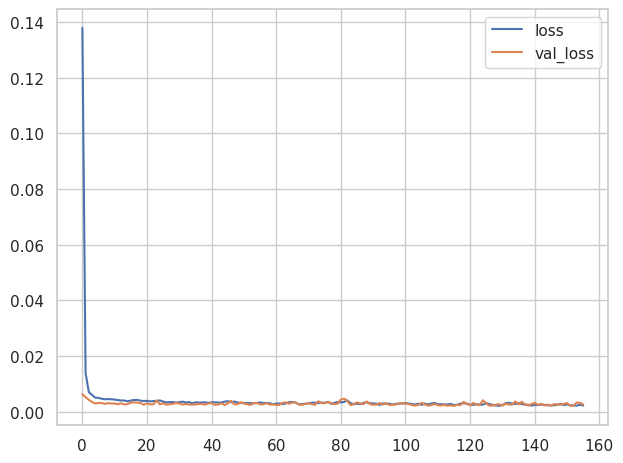

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=500,
    callbacks=[early_stopping], # put callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)#this creates a new df that keeps track of the training/validation 
history_df.loc[:, ['loss', 'val_loss']].plot();#this is used to visualize the loss history

print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
print("Minimum training loss: {}".format(history_df['loss'].min()))

In [11]:
#This is the models first predictions being saved and assigned to variable FIRST_PRED
FIRST_PRED = model.predict(X_test)
FIRST_PRED = pd.DataFrame(FIRST_PRED)

6/6 [==============================] - 0s 2ms/step


In [12]:
from sklearn.metrics import mean_absolute_error, r2_score

In [13]:
testplot = y_test
modelplot = FIRST_PRED

In [14]:
modelplot=modelplot.rename(columns={0: 'predicted'})
testplot =testplot.rename(columns= {'taut': 'actual'})
compare = pd.concat([modelplot, testplot], axis=1)

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

actual_values = compare['actual']
predicted_values = compare['predicted']

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

In [16]:
predicted_values = compare["predicted"].values
actual_values = compare["actual"].values

# This function calculates the Mean Absolute Percentage Error
def m_a_p_e(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))* 100

mape = m_a_p_e(actual_values, predicted_values)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

MAE: 0.019658400938923053
MSE: 0.0020816124284521857
R^2: 0.746361474822356
Mean Absolute Percentage Error (MAPE): 3.31%


# Testing the model's predictions

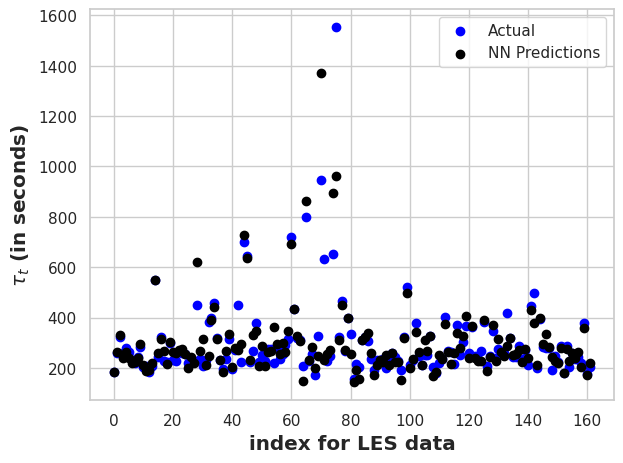

In [17]:
unscale_test = unscale_values(testplot,min_['taut'], max_['taut'])
unscale_model = unscale_values(modelplot,min_['taut'], max_['taut'])

# Create a scatter plot
plt.scatter(unscale_test.index,unscale_test, color='blue', label='Actual')
plt.scatter(unscale_model.index, unscale_model, color='black', label='NN Predictions')

# Add labels and title
plt.xlabel('index for LES data')
plt.ylabel(r'$\tau_t$'+ " (in seconds)")
#plt.title('Actual vs. Predicted Values')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [18]:
unscale_test = unscale_values(testplot, min_['taut'], max_['taut'])

unscale_model = unscale_values(modelplot, min_['taut'], max_['taut'])

# Create a DataFrame to hold the unscaled actual and predicted values
resu = pd.DataFrame({
    'Actual': unscale_test.iloc[:,0],
    'Predicted': unscale_model.iloc[:,0]
})

# Calculating the Mean Absolute Percentage Error (MAPE)
#mape_final = 100 * np.mean(np.abs((resu['Actual'] - resu['Predicted']) / resu['Actual']))
mape_final = m_a_p_e(resu['Actual'],resu['Predicted'])
print(f"The final MAPE for the unscaled actual data and the unscaled predictions is {mape_final:.2f}%")

The final MAPE for the unscaled actual data and the unscaled predictions is 9.56%


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 134,145
Trainable params: 134,145
Non-trainable params: 0
_________________________________________________________________
